## Introduction



This tutorial shows how to generate the data needed for the simple map2parameter simulation. It
generates the expected noise power spectra of the Simons Observatory (SO) large aperture telescope
and the expected Planck white noise power spectra. It also generates beam files for SO and Planck.



## Preamble



`matplotlib` magic



In [1]:
%matplotlib inline

Versions used for this tutorial



In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp
import pspipe
import pspy
import camb
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("    healpy :", hp.__version__)
print("     psipe :", pspipe.__version__)
print("      pspy :", pspy.__version__)
print("      camb :", camb.__version__)

     Numpy : 1.18.1
Matplotlib : 3.1.2
    healpy : 1.13.0
     psipe : 0+untagged.649.gb59d5db
      pspy : 1.0.0+130.g2de8443
      camb : 1.1.0


For this notebook, we will also need the `mflike` likelihood and the SO noise calculator



In [3]:
import mflike
import so_noise_calculator_public_20180822 as noise_calc

Finally we use the Planck colormap as default *via* `pixell`



In [4]:
from pixell import colorize
colorize.mpl_setdefault("planck")

## Prepare simulation data



### Multipole range & experiment frequency channels



Simulations will be generated between $\ell_text{min} = 2$ and $\ell_\text{max} = 10^4$



In [5]:
ell_min, ell_max = 2, 10000
ell = np.arange(ell_min, ell_max)

Frequencies in GHz used by SO and Planck experiments are



In [6]:
frequencies = {
    "LAT": ["27", "39", "93", "145", "225", "280"],
    "Planck": ["100", "143", "217", "353"]
}

and the relevant cross frequency pairs



In [7]:
f_pairs_LAT = ["LAT_27xLAT_27",
               "LAT_39xLAT_39",
               "LAT_93xLAT_93",
               "LAT_145xLAT_145",
               "LAT_225xLAT_225",
               "LAT_280xLAT_280",
               "LAT_27xLAT_39",
               "LAT_93xLAT_145",
               "LAT_225xLAT_280"]
from itertools import combinations_with_replacement as cwr
f_pairs_Planck = ["Planck_{}xPlanck_{}".format(*cross) for cross in cwr(frequencies["Planck"], 2)]

### Theoritical input spectra



Using [CAMB](https://camb.readthedocs.io/en/latest/) and a set of cosmological parameters, we can produce $C_\ell$ for the different spectra



In [8]:
cosmo_params = {
    "H0": 67.5,
    "As": 1e-10*np.exp(3.044),
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544
}
pars = camb.set_params(**cosmo_params)
pars.set_for_lmax(ell_max, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

and plot the results



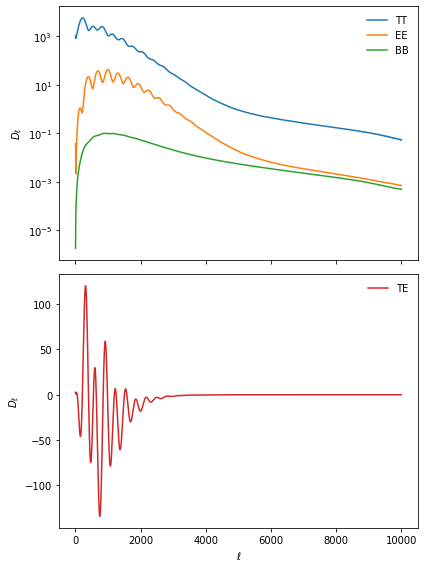

In [9]:
spectra = ["tt", "ee", "bb", "te"]
dls = {cl: powers["total"][ell_min:ell_max, i]
       for i, cl in enumerate(spectra)}
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axes[0].set_yscale("log")
for i, (spec, dl) in enumerate(dls.items()):
    ax = axes[1] if spec == "te" else axes[0]
    ax.plot(ell, dl, "-C{}".format(i), label=spec.upper())

for ax in axes:
    ax.set_ylabel(r"$D_\ell$")
    ax.legend()
    axes[1].set_xlabel(r"$\ell$")
    plt.tight_layout()

### Generation of foregrounds



To produce foreground levels, we use the `fgspectra` library
[https://github.com/simonsobs/fgspectra](https://github.com/simonsobs/fgspectra). We only consider foreground components for the temperature
cross-spectra and for the main LAT frequencies (93, 145 and 225 GHz) The foreground model is made of

-   a kSZ and tSZ components,
-   a cibp and a cibc components,
-   a radio component

with the following foreground parameters



In [10]:
fg_params = {
  "a_tSZ": 3.30,
  "a_kSZ": 1.60,
  "a_p": 6.90,
  "beta_p": 2.08,
  "a_c": 4.90,
  "beta_c": 2.20,
  "n_CIBC": 1.20,
  "a_s": 3.10,
  "T_d": 9.60
}

Given the above parameters, each component is added to the `model` dictionary and computed for the
three main LAT frequencies



In [11]:
all_freqs = np.array([93, 145, 225])

nu_0 = 150.0
ell_0 = 3000
T_CMB = 2.725

from fgspectra import cross as fgc
from fgspectra import power as fgp
from fgspectra import frequency as fgf
ksz = fgc.FactorizedCrossSpectrum(fgf.ConstantSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
cibc = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())

model = {}
model["tt", "kSZ"] = fg_params["a_kSZ"] * ksz(
    {"nu": all_freqs},
    {"ell": ell, "ell_0": ell_0})
model["tt", "cibp"] = fg_params["a_p"] * cibp(
    {"nu": all_freqs, "nu_0": nu_0, "temp": fg_params["T_d"], "beta": fg_params["beta_p"]},
    {"ell": ell, "ell_0": ell_0, "alpha": 2})
model["tt", "radio"] = fg_params["a_s"] * radio(
    {"nu": all_freqs, "nu_0": nu_0, "beta": -0.5 - 2},
    {"ell": ell, "ell_0": ell_0, "alpha": 2})
model["tt", "tSZ"] = fg_params["a_tSZ"] * tsz(
    {"nu": all_freqs, "nu_0": nu_0},
    {"ell": ell, "ell_0": ell_0})
model["tt", "cibc"] = fg_params["a_c"] * cibc(
    {"nu": all_freqs, "nu_0": nu_0, "temp": fg_params["T_d"], "beta": fg_params["beta_c"]},
    {"ell": ell, "ell_0": ell_0, "alpha": 2 - fg_params["n_CIBC"]})

We can plot foreground shape given cross frequencies and compare it to signal power spectra



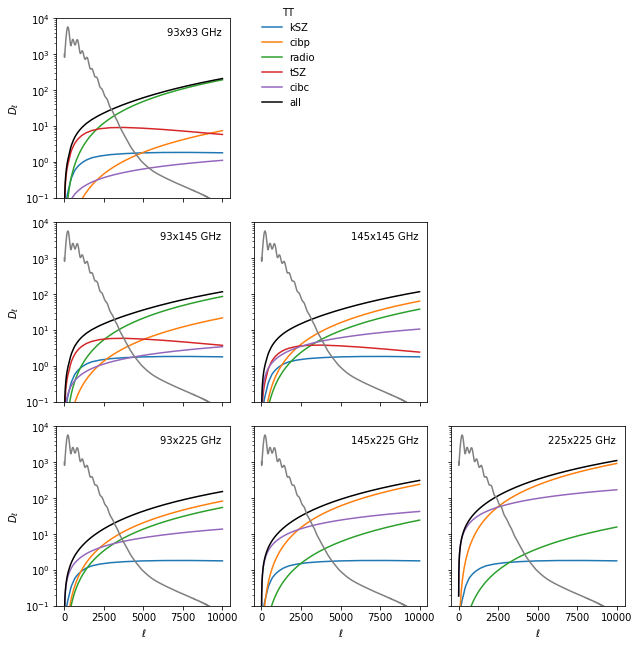

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
from itertools import product
for i, cross in enumerate(product(all_freqs, all_freqs)):
    idx = (i%3, i//3)
    ax = axes[idx]
    if idx in zip(*np.triu_indices(3, k=1)):
        fig.delaxes(ax)
        continue
    fg_sum = np.zeros_like(ell, dtype=np.float)
    for k, v in model.items():
        ax.plot(ell, v[idx])
        fg_sum += v[idx]
    ax.plot(ell, fg_sum, color="black")
    ax.plot(ell, dls["tt"], color="gray")
    ax.legend([], title="{}x{} GHz".format(*cross))
    ax.set_yscale("log")
    ax.set_ylim(10**-1, 10**4)

for i in range(3):
  axes[-1, i].set_xlabel("$\ell$")
  axes[i, 0].set_ylabel("$D_\ell$")
fig.legend([c[1] for c in model.keys()] + ["all"], title="TT", bbox_to_anchor=(0.5,1))
plt.tight_layout()

### Computation of experimental noise



The noise levels in temperature and polarisation are stored within two dictionaries



In [13]:
from copy import deepcopy
n_ell_t = {"LAT_{}xLAT_{}".format(*cross): ell * 0. for cross in cwr(frequencies["LAT"], 2)}
n_ell_pol = deepcopy(n_ell_t)

#### SO noise



We start with SO, for which we have to specify a sensitivity mode (1: baseline, 2:goal), and a
fraction of sky to calculate the associated noise level



In [14]:
sensitivity_mode = 1
fsky = 0.4

We use the SO noise calculator to compute the expected noise in temperature and polarisation



In [15]:
ell, n_ell_t_LAT, n_ell_pol_LAT, _ = noise_calc.Simons_Observatory_V3_LA_noise(sensitivity_mode,
                                                                               fsky,
                                                                               ell_min,
                                                                               ell_max,
                                                                               delta_ell=1,
                                                                               apply_beam_correction=False)
for i, f_pair in enumerate(f_pairs_LAT):
  n_ell_t[f_pair] = n_ell_t_LAT[i]
  n_ell_pol[f_pair] = n_ell_pol_LAT[i]

#### Planck noise



We will use information from the Table 4 of [https://arxiv.org/pdf/1807.06205.pdf](https://arxiv.org/pdf/1807.06205.pdf). Planck noise will
be assumed to be white for these simulations and Planck standard deviations are in µK.arcmin.



In [16]:
sigma = {"Planck_{}xPlanck_{}".format(*cross): 0. for cross in cwr(frequencies["Planck"], 2)}
sigma_pol = deepcopy(sigma)

sigma["Planck_100xPlanck_100"] = 77.4
sigma["Planck_143xPlanck_143"] = 33.0
sigma["Planck_217xPlanck_217"] = 46.80
sigma["Planck_353xPlanck_353"] = 153.6

sigma_pol["Planck_100xPlanck_100"] = 117.6
sigma_pol["Planck_143xPlanck_143"] = 70.2
sigma_pol["Planck_217xPlanck_217"] = 105.0
sigma_pol["Planck_353xPlanck_353"] = 438.6

for f_pair in f_pairs_Planck:
    sigma_rad = np.deg2rad(sigma[f_pair]) / 60
    n_ell_t[f_pair] = ell * 0 + sigma_rad**2
    sigma_pol_rad = np.deg2rad(sigma_pol[f_pair]) / 60
    n_ell_pol[f_pair] = ell * 0 + sigma_pol_rad**2

### Generation of beam harmonics



Finally let's generate the beam harmonic transform for Planck and SO LAT. For Planck we will use
information from the Table 4 of [https://arxiv.org/pdf/1807.06205.pdf](https://arxiv.org/pdf/1807.06205.pdf). For SO we use info from Table
1 of [https://arxiv.org/pdf/1808.07445.pdf](https://arxiv.org/pdf/1808.07445.pdf)



In [17]:
beam_fwhm = {}
beam_fwhm["LAT_27"] = 7.4
beam_fwhm["LAT_39"] = 5.1
beam_fwhm["LAT_93"] = 2.2
beam_fwhm["LAT_145"] = 1.4
beam_fwhm["LAT_225"] = 1.0
beam_fwhm["LAT_280"] = 0.9

beam_fwhm["Planck_100"] = 9.68
beam_fwhm["Planck_143"] = 7.30
beam_fwhm["Planck_217"] = 5.02
beam_fwhm["Planck_353"] = 4.94

Store $b_\ell$ and plot them



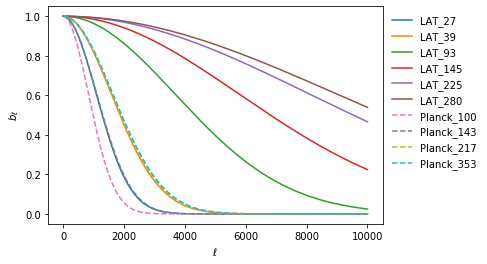

In [18]:
bl = {}
from pspy import pspy_utils
for exp, freqs in frequencies.items():
  for freq in freqs:
    name = "{}_{}".format(exp, freq)
    ell_bl, bl[name] = pspy_utils.beam_from_fwhm(beam_fwhm[name], ell_max)
    plt.plot(ell_bl, bl[name], label=name, linestyle="-" if exp == "LAT" else "--")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$b_{\ell}$")
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

### Plotting noise levels



Given beam transform harmonics, we can now compare the noise power spectra with signal power spectra
previously generated with [CAMB](https://camb.readthedocs.io/en/latest/). Let's plot everything together



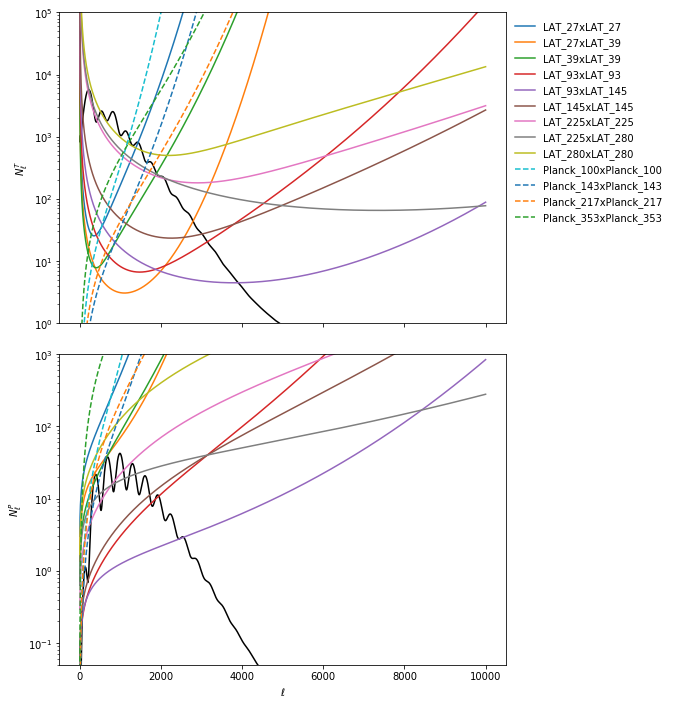

In [19]:
plt.figure(figsize=(8, 12))
grid = plt.GridSpec(2, 1, hspace=0.1, wspace=0)

fac = ell * (ell + 1) / (2*np.pi)

TT = plt.subplot(grid[0], xticklabels=[])
TT.semilogy()
TT.set_ylim(1, 10**5)
TT.set_ylabel(r"$N^{T}_{\ell}$")
TT.plot(ell, dls["tt"], "k")

EE = plt.subplot(grid[1])
EE.semilogy()
EE.set_ylim(0.05, 10**3)
EE.set_xlabel(r"$\ell$")
EE.set_ylabel(r"$N^{P}_{\ell}$")
EE.plot(ell, dls["ee"], "k")

for exp, freqs in frequencies.items():
  for f1, f2 in cwr(freqs, 2):
    name1, name2 = "{}_{}".format(exp, f1), "{}_{}".format(exp, f2)
    name = "{}x{}".format(name1, name2)
    # Plot only non-zero noise
    if not np.any(n_ell_t[name]): continue

    TT.plot(ell, n_ell_t[name] * fac / (bl[name1] * bl[name2]), label=name,
            linestyle="-" if exp == "LAT" else "--")
    EE.plot(ell, n_ell_pol[name] * fac / (bl[name1] * bl[name2]), label=name,
            linestyle="-" if exp == "LAT" else "--")

TT.legend(loc="upper left", bbox_to_anchor=(1,1));

### Binning



We create a binning file made of 200 bins with an adaptative bin size. The output file has 3
columns : $\ell$<sub>min</sub>, $\ell$<sub>max</sub>, $\ell$<sub>mean</sub>



In [20]:
n_bins = 200
bin_size = np.empty(n_bins)
bin_size[0] = 50
bin_size[1:80] = 35
bin_size[80:100] = 60
bin_size[100:] = 100

bin_min = 2
bins = np.empty((n_bins, 3))
for i, bs in enumerate(bin_size):
    bin_max = bin_min + bs
    bins[i] = bin_min, bin_max, np.mean([bin_min, bin_max])
    bin_min += bs + 1

binning_file = "/tmp/binning.dat"
np.savetxt(binning_file, bins)

## Compute mode coupling matrices and window functions



We now have to compute the window functions, the mode coupling matrices (mcm) and the binning
matrices (bbl) for the different frequency channels of the different CMB experiments. For
illustrative purposes, everything will be done at low resolution namely `nside=1024` to reduce time
computation.



### Mask and window functions



We generate window function by considering three masks:

-   a galactic mask,
-   a survey mask,
-   a point source mask.

Galactic and survey masks are pure `numpy` arrays



In [21]:
galactic_mask = np.load("./masks/mask_equatorial_1024.npz")["mask"]
survey_mask = np.load("./masks/survey_mask_1024.npz")["mask"]

The point source mask is made of 100 holes each of 10 arcmin size that we apodize with a 'C1'
apodization scheme and 0.3 degree size. We build it on top of a `HEALPIX` map with `nside=1024`



In [22]:
from pspy import so_map
mask = so_map.healpix_template(ncomp=1, nside=1024)
mask.data[:] = 1
from pspy import so_window
mask = so_map.simulate_source_mask(mask, n_holes=100, hole_radius_arcmin=10)
point_source_mask = so_window.create_apodization(mask, apo_type="C1", apo_radius_degree=0.3)

Let's plot them next to each other



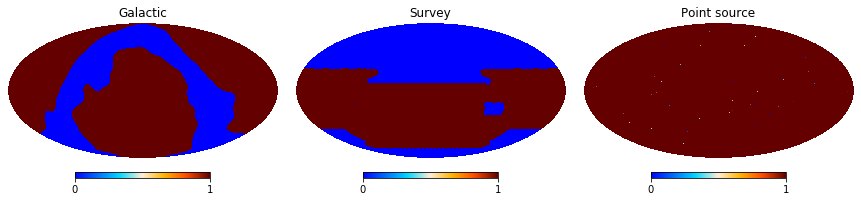

In [23]:
plt.figure(figsize=(12, 4))
hp.mollview(galactic_mask, title="Galactic", sub=(1, 3, 1))
hp.mollview(survey_mask, title="Survey", sub=(1, 3, 2))
hp.mollview(point_source_mask.data, title="Point source", sub=(1, 3, 3))

Now, let's build the window by adding each mask (galactic and survey masks are first apodized with a
5° beam)



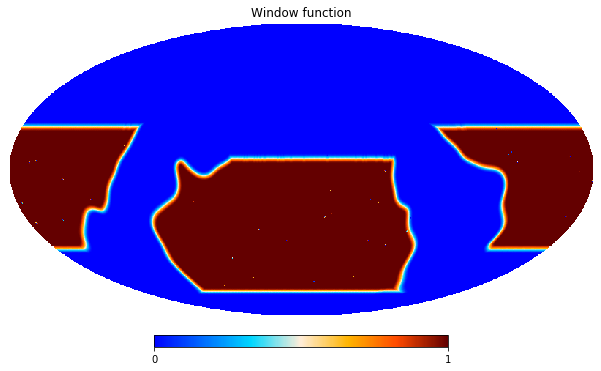

In [24]:
window = so_map.healpix_template(ncomp=1, nside=1024)
window.data[:] = 1
window.data *= galactic_mask.data
window.data *= survey_mask.data
window = so_window.create_apodization(window, apo_type="C1", apo_radius_degree=5)
window.data *= point_source_mask.data

hp.mollview(window.data, title="Window function")

### Mode coupling matrices



Next step consists to compute the mode coupling matrices and binning matrices for the different
cross spectra given the window function and the beam harmonics transform computed above. We only
consider LAT experiment with the three main frequency channels.



In [25]:
frequencies = {"LAT": ["93", "145", "225"]}

For spin 0 and 2 the window need to be a tuple made of two objects: the window used for spin 0 and
the one used for spin 2. Nevertheless, within this simple notebook, the window functions are the
same over the different frequency. Consequently, the `win1` and `win2` arguments of
`so_mcm.mcm_and_bbl_spin0and2` function are the same and consists of a tuple of two window
function. In more general case, this will be different.

For each cross spectra *i.e.* `LAT_93xLAT_93`&#x2026; we store the mcm and bbl matrices as follow



In [26]:
from pspy import so_mcm
mbb_inv, bbl = {}, {}
for f1, f2 in cwr(frequencies["LAT"], 2):
  name = "LAT{}xLAT{}".format(f1, f2)
  print("Processing {}...".format(name))
  mbb_inv[name], bbl[name] = so_mcm.mcm_and_bbl_spin0and2(win1=(window, window),
                                                          win2=(window, window),
                                                          bl1=(bl["LAT_" + f1], bl["LAT_" + f1]),
                                                          bl2=(bl["LAT_" + f2], bl["LAT_" + f2]),
                                                          binning_file=binning_file,
                                                          niter=3,
                                                          type="Dl",
                                                          lmax=2000,
                                                          lmax_pad=2500)

Processing LAT93xLAT93...
Processing LAT93xLAT145...
Processing LAT93xLAT225...
Processing LAT145xLAT145...
Processing LAT145xLAT225...
Processing LAT225xLAT225...


We can plot the $M_{bb}^{-1}$ matrix



<ipython-input-27-8e381bb64655>:18: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(np.abs(mcm)), vmin=vmin, vmax=vmax)


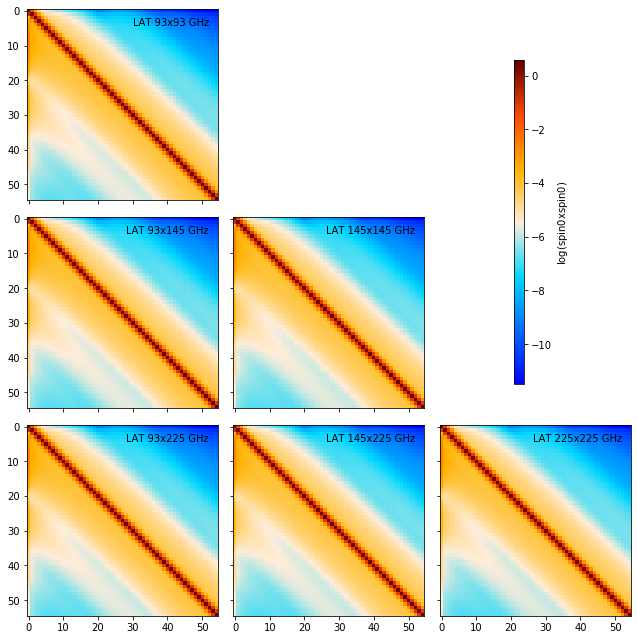

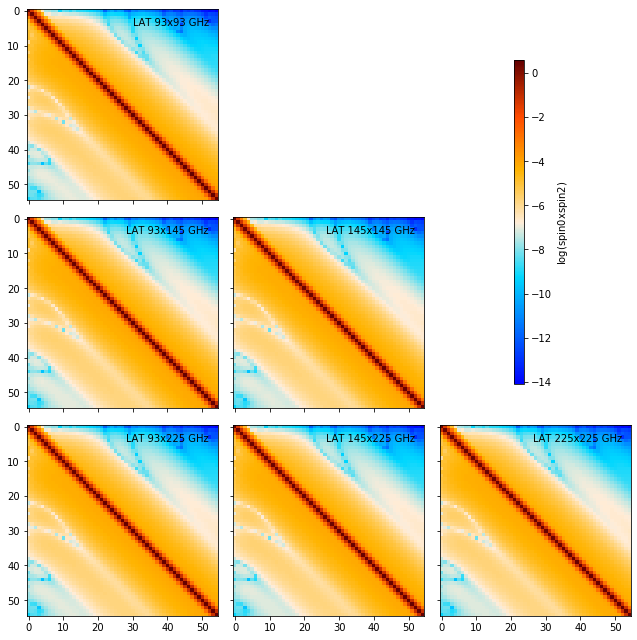

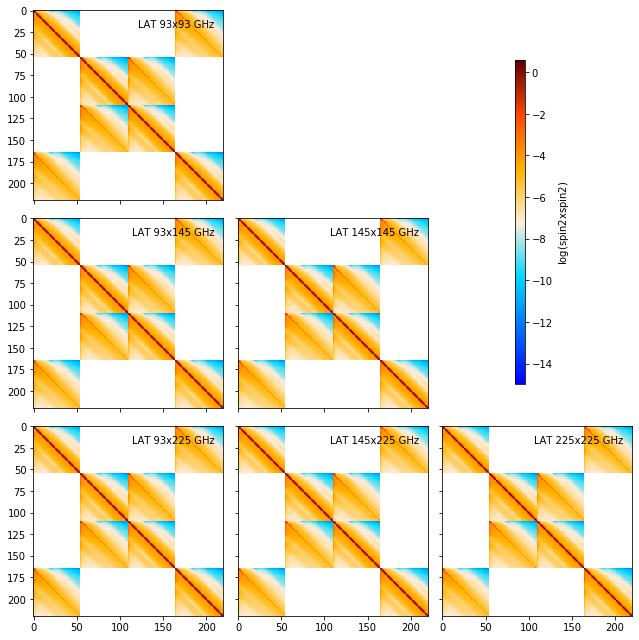

In [27]:
# for spin in ["spin0xspin0", "spin0xspin2", "spin2xspin2"]:
def plot_mcm(spin):
    def _get_min_max():
        a = np.concatenate([np.log10(np.abs(v2+1e-15)) for k1, v1 in mbb_inv.items()
                            for k2, v2 in v1.items() if k2 == spin])
        return np.min(a), np.max(a)
    vmin, vmax = _get_min_max()
    fig, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
    from itertools import product
    for i, cross in enumerate(product(frequencies["LAT"], frequencies["LAT"])):
        idx = (i%3, i//3)
        ax = axes[idx]
        if idx in zip(*np.triu_indices(3, k=1)):
            fig.delaxes(ax)
            continue
        name = "LAT{}xLAT{}".format(*cross)
        mcm = mbb_inv[name][spin]
        im = ax.imshow(np.log10(np.abs(mcm)), vmin=vmin, vmax=vmax)
        ax.legend([], title="LAT {}x{} GHz".format(*cross))
    plt.tight_layout()
    # Now adding the colorbar
    cbaxes = fig.add_axes([0.8, 0.4, 0.015, 0.5])
    cb = plt.colorbar(im, cax=cbaxes)
    cb.set_label("$\log$(%s)" % spin)
plot_mcm(spin="spin0xspin0")
plot_mcm(spin="spin0xspin2")
plot_mcm(spin="spin2xspin2")

We can also plot the diagonal terms of the $M_{bb}^{-1}$ for the different spin combinations



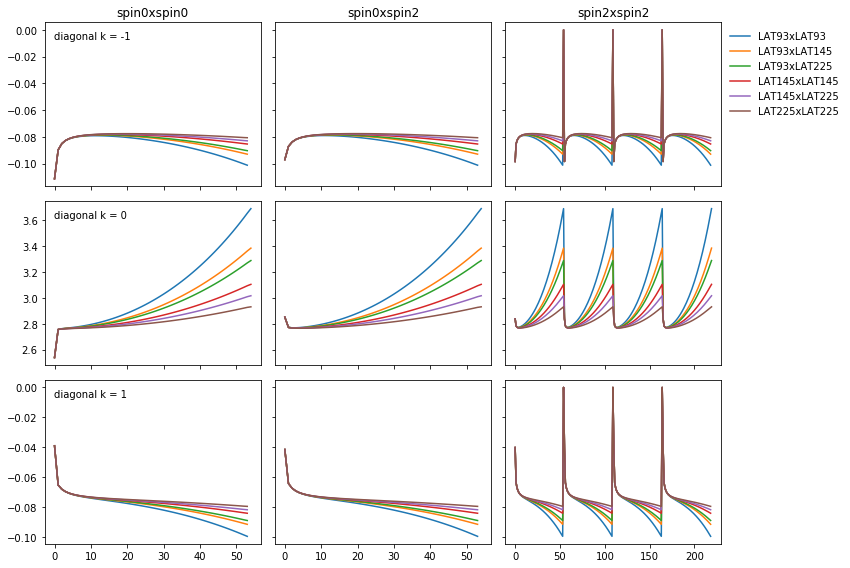

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharey="row", sharex="col")
for cross, spins in mbb_inv.items():
    for i, spin in enumerate(["spin0xspin0", "spin0xspin2", "spin2xspin2"]):
        for k in [-1, 0, +1]:
            if i == 0:
              axes[k+1, i].legend([], title="diagonal k = {}".format(k), loc="upper left")
            axes[k+1, i].plot(np.diag(spins[spin], k=k), label=cross)

        axes[0, i].set_title(spin)
    axes[0, -1].legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()